Author: Roméo Juge (romeo.juge@proton.me)

In [1]:
### Import des librairies et fonctions utilisateur
import importlib
import myfun_OPERAT
importlib.reload(myfun_OPERAT)
from myfun_OPERAT import *

# Import variables stockées en mémoire (local)
%store -r OPERAT
%store -r df
%store -r CAP

# <font color=cyan>Import données</font>

- Import données OPERAT et formattage
- Import liste catégories et bornes

## <font color=yellow>Données OPERAT</font>

Cas où les données OPERAT sont en 1 seul fichier csv.

In [ ]:
file_path = r"C:\Users\romeo\OID Dropbox\Romeo Juge\OID - Mission OPERAT 2023\4. BDD\Consommations OPERAT au 12092023_ envoi OID.xlsx"

print("Importing data...")
warnings.simplefilter(action="ignore", category=UserWarning)
OPERAT = pd.read_excel(file_path,
                  sheet_name = 0,
                  header = 0,
                  skiprows = 0,
                  dtype = object)
warnings.resetwarnings()
print("DATA IMPORT COMPLETE")

Cas où les données OPERAT sont divisées en plusieurs fichiers (par année par exemple). <br>
Import de chaque fichier séparément et concaténation en 1 seul dataframe.

In [43]:
# Import de tous les fichiers dans un dossier puis concaténation
path = r"C:\Users\romeo\OID Dropbox\Romeo Juge\Marché Appui OPERAT\Mission 2023\3. Analyse données\01. BDD OPERAT\20243101"
file_list = os.listdir(path)

OPERAT = pd.DataFrame()
for file in file_list:
    
    print("Importing '{}' ...".format(file))
    file_path = r"{}\{}".format(path, file)
    OPERAT_1Y = pd.read_csv(file_path, sep=';', encoding='utf_8', dtype='object')
    OPERAT = pd.concat([OPERAT, OPERAT_1Y])

OPERAT = OPERAT.sort_values('id')
OPERAT = OPERAT.reset_index(drop=True)

print("------------------------------")
print("Import complete")

Importing 'export_requete_2020_202402011403.csv' ...
Importing 'export_requete_2021_202402020941.csv' ...
Importing 'export_requete_2022_202402011154.csv' ...
Importing 'export_requete_reference_202402011249.csv' ...
------------------------------
Import complete


Conversion des colonnes au bon data type (float, int, date, string)

In [44]:
col_float = ["Surface moyenne annuelle catégorie d'activité majoritaire (m²)",
             "Surface moyenne annuelle catégorie d'activité secondaire (m²)",
             'Surface totale brute (m²)',
             'Surface moyenne annuelle totale chauffée',
             'Surface moyenne annuelle totale refroidie',
             'Surface moyenne annuelle totale froid process',
             "Surface moyenne annuelle sous-catégorie d'activité majoritaire (m²)",
             "Surface moyenne annuelle sous-catégorie d'activité secondaire (m²)",
             'Surface moyenne annuelle',
             'Consommation totale (kWh PCI)',
             'Ratio (kWh PCI / m2)',
             'Surface moyenne annuel  local vacant (m²)',
             'Surface moyenne annuelle catégorie "Stationnement" (m²)',
             'Electricite (kWh)',
             'Gaz naturel - reseaux (kWh)',
             'Gaz naturel liquefie (kg) - kWh',
             'Gaz propane (kg) - kWh',
             'Gaz propane (m3) - kWh',
             'Gaz butane (kg) - kWh',
             'Gaz butane (m3) - kWh',
             'Fioul domestique (l) - kWh',
             'Charbon - agglomeres et briquettes (kg)- kWh',
             'Houille (kg) - kWh',
             "Bois - Plaquettes d'industrie (kg) - kWh",
             'Bois - Plaquettes forestieres (kg) - kWh',
             'Bois - Granules (pellets) ou briquettes (kg) - kWh',
             'Bois - Buches (stere)-kWh',
             'Reseau de chaleur (kWh)',
             'Reseau de froid (kWh)',
             'Consommation usages chauffage (kWh PCI)',
             'Consommation usages refroidissement (kWh PCI)',
             'Consommation usages froid process (kWh PCI)',
             'Consommation totale IRVE']

col_int = ['id', 
           'ID interne EFA',
           'Nb sous categories distinctes',
           'Nb categories distinctes',
           'NB Bornes recharge IRVE']

col_date = ['Date de début de la déclaration']

col_not_string = col_float + col_int + col_date
col_string = [x for x in OPERAT.columns.to_list() if x not in col_not_string]

# Application des types de données attendus
for column in col_float:
    OPERAT[column] = OPERAT[column].astype('string').str.strip().str.replace(',','.').astype('float')

for column in col_int:
    OPERAT[column] = OPERAT[column].astype('string').str.strip().str.replace(',','.').astype('float').astype('Int32')

for column in col_date:
    OPERAT[column] = pd.to_datetime(OPERAT[column], dayfirst=True, errors='coerce')
        
for column in col_string:
    OPERAT[column] = OPERAT[column].astype('string').str.strip()

## <font color=yellow>Import liste catégories et bornes</font>

Import du fichier contenant la liste des catégories (CAP, SCAP, méta-catégories) et les bornes surfaciques

In [45]:
# Import de la liste des catégories et des bornes
file_path = r"C:\Users\romeo\OID Dropbox\Romeo Juge\Marché Appui OPERAT\Mission 2023\3. Analyse données\02. Méthodologie\bornes_CAP_v5.0.xlsx"

warnings.simplefilter(action="ignore")
CAP = pd.read_excel(file_path,
                  sheet_name = "Catégories & Sous-catégories",
                  header = 0,
                  skiprows = 0,
                  dtype = object)
warnings.resetwarnings()

# Corrections préliminaires (au cas où)
CAP = CAP.map(lambda x: x.replace("’", "'") if isinstance(x, str) else x, na_action="ignore")
CAP = CAP.map(lambda x: " ".join(x.split()) if isinstance(x, str) else x, na_action="ignore")
CAP = CAP.map(lambda x: x.strip() if isinstance(x, str) else x, na_action="ignore")

# Liste des CAP et SCAP possibles (v5)
list_CAP = CAP.loc[CAP["Type"] == "Catégorie"]["Catégories et sous-catégories"].value_counts().index.to_list()
list_SCAP = CAP.loc[CAP["Type"] == "Sous-Catégorie"]["Catégories et sous-catégories"].value_counts().index.to_list()

# stockage variable en mémoire (local)
%store CAP 

Stored 'CAP' (DataFrame)


# <font color=cyan>Traitement des données</font>

<font color=yellow>**Corrections préliminaires**</font>
- Formattage : suppression des lignes vides, conversion des apostrophes, suppression des espaces multiples, suppression des espaces en début et fin de chaîne de caractères
- Correction des CAP et SCAP :
    - Renommage des CAP pour qu'elles correspondent à la dernière version (v5.0)
    - Certaines SCAP sont en réalité des CAP : on remplace par la SCAP par défaut quand on en trouve
    - Renommage des SCAP pour qu'elles correspondent à la dernière version (v5.0)

<font color=yellow>**Scores de fiabilité**</font> <br>
<font color=greenyellow>*Score P&S*</font>
- Ajout des colonnes contenant le code de la CAP-M et de la CAP-S à la base
- Ajout de la colonne "PS Score" et calcul du score de fiabilité PS

<font color=greenyellow>*Score E*</font>
- Ajout de la colonne "E Score" et calcul du score de fiabilité E

## <font color=yellow>Corrections préliminaires</font>

Formattage : suppression des lignes vides, conversion des apostrophes, suppression des espaces multiples, suppression des espaces en début et fin de chaîne de caractères

In [46]:
OPERAT.dropna(axis=0, how="all", inplace=True) 
OPERAT = OPERAT.map(lambda x: x.replace("’", "'") if isinstance(x, str) else x, na_action="ignore")
OPERAT = OPERAT.map(lambda x: " ".join(x.split()) if isinstance(x, str) else x, na_action="ignore")
OPERAT = OPERAT.map(lambda x: x.strip() if isinstance(x, str) else x, na_action="ignore")

Ce bloc retourne les CAP et les SCAP qui ne sont pas dans la liste des options disponibles dans la version du fichier d'import csv importé plus haut.

In [49]:
#############################################################################################
######################### Liste des CAP et SCAP de la base ##################################
#############################################################################################

# Liste des colonnes contenant des CAP et des SCAP
col_CAP = ["Categorie d'activite majoritaire", "Categorie d'activite secondaire", "Categorie d'activite principale"]
col_SCAP = ["Sous Categorie d'activite majoritaire", "Sous-catégorie d'activité secondaire"]

# Liste des CAP renseignées dans la base
list_CAP_OPERAT = OPERAT[col_CAP[0]]
for i in range(1, len(col_CAP)):
    list_CAP_OPERAT = pd.concat([list_CAP_OPERAT, OPERAT[col_CAP[i]]])
list_CAP_OPERAT = list_CAP_OPERAT.value_counts().index.to_list() 

# Liste des SCAP renseignées dans la base
list_SCAP_OPERAT = OPERAT[col_SCAP[0]]
for i in range(1, len(col_SCAP)):
    list_SCAP_OPERAT = pd.concat([list_SCAP_OPERAT, OPERAT[col_SCAP[i]]])
list_SCAP_OPERAT = list_SCAP_OPERAT.value_counts().index.to_list() 

# CAP de la base qui ne sont pas dans la dernière version
print("CAP pas dans la liste des options possibles (v5) :\n")
print([x for x in list_CAP_OPERAT if x not in list_CAP])

# SCAP de la base qui ne sont pas dans la dernière version
print("\n---------------------------------------------------------------------------------------")
print("SCAP pas dans la liste des options possibles (v5) :\n")
[x for x in list_SCAP_OPERAT if x not in list_SCAP]

CAP pas dans la liste des options possibles (v5) :

['Commerces', 'Culture et spectacles', 'Vente et service automobile, moto, véhicules industriels, nautique', 'Audiovisuel']

---------------------------------------------------------------------------------------
SCAP pas dans la liste des options possibles (v5) :



['Cafétéria (service de boissons chaudes, sandwiches et plats à réchauffer au micro-ondes)',
 'Commerces',
 'Culture et spectacles',
 'Restauration en service continu en libre-service (avec plateaux) - Self',
 'Vente et service automobile, moto, véhicules industriels, nautique',
 'Audiovisuel']

Correction des CAP et SCAP :
- Renommage des CAP pour qu'elles correspondent à la dernière version (v5.0)
- Certaines SCAP sont en réalité des CAP : on remplace par la SCAP par défaut quand on en trouve
- Renommage des SCAP pour qu'elles correspondent à la dernière version (v5.0)
- (exécuter le bloc précédent après celui-ci pour vérifier les erreurs restantes)

In [48]:
#############################################################################################
######### Renommage des CAP pour qu'elles correspondent à la dernière version (v5) ###########
#############################################################################################
CAP_renaming = {"Enseignement secondaire": "Enseignement Secondaire",
                "Enseignement supérieur": "Enseignement Supérieur",
                "Gares routières": "Transport urbain de voyageurs (métro)",
                "Restauration": "Restauration - Débit de boissons",
                "Résidences de tourisme et de loisirs": "Résidence de tourisme et loisirs",
                "Santé et action sociale": "Santé - Etablissements médico-sociaux",
                "Résidences de tourisme et villages ou clubs de vacances": "Résidence de tourisme et loisirs"}

OPERAT[col_CAP] = OPERAT[col_CAP].replace(CAP_renaming)

#############################################################################################
####### Renomage des SCAP pour qu'elles correspondent à la dernière version (v5) ############
#############################################################################################

# Certaines sous-catégories sont en réalité des catégories. Lorsque c'est le cas, on remplace par la sous-catégorie par défaut.

# On renomme d'abord les SCAP (cette fonction ne va s'appliquer qu'aux SCAP qui sont des CAP)
OPERAT[col_SCAP] = OPERAT[col_SCAP].replace(CAP_renaming)

# Liste des SCAP renseignées par les assujettis dans OPERAT
col_SCAP_M = "Sous Categorie d'activite majoritaire"
col_SCAP_S = "Sous-catégorie d'activité secondaire"
list_SCAP_M = OPERAT[col_SCAP_M].value_counts().index.to_list()
list_SCAP_S = OPERAT[col_SCAP_S].value_counts().index.to_list()
list_SCAP_OPERAT = list(set(list_SCAP_M + list_SCAP_S))

# Pour chaque SCAP renseignée qui est dans la liste des CAP
for scap in [x for x in list_SCAP_OPERAT if x in list_CAP]:
    
    # On récupère le code de la CAP correspondante
    code_CAP = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Catégories et sous-catégories"] == scap]["Code"].iloc[0]

    # Puis on récupère la liste des SCAP correspondant à cette CAP
    scap_list = CAP.loc[CAP["Type"] == "Sous-Catégorie"].loc[CAP["Code"].fillna("").str.contains(code_CAP)]["Catégories et sous-catégories"].to_list()

    # On sélectionne la SCAP par défaut (si elle existe, sinon, on passe) et on remplace dans les données OPERAT
    default_scap = [x for x in scap_list if 'defaut' in unicodedata.normalize('NFKD', x).encode('ASCII', 'ignore').decode('ASCII').lower()]
    if len(default_scap) == 1:
        
        default_scap = default_scap[0]
    
        idx_m = OPERAT.loc[OPERAT[col_SCAP_M] == scap].index
        idx_s = OPERAT.loc[OPERAT[col_SCAP_S] == scap].index
        if len(idx_m) != 0:
            OPERAT.loc[idx_m, col_SCAP_M] = default_scap
        if len(idx_s) != 0:
            OPERAT.loc[idx_s, col_SCAP_S] = default_scap
    
    else:
        continue

# Renomage des SCAP pour qu'elles correspondent à la dernière version (v5)[
# {"ancien nom": "nouveau nom (à jour)"}
SCAP_renaming = {"Activité de santé libérale - Kinésithérapie, Rééducation fonctionnelle": "Activité de santé libérale - Kinésithérapie, Rééducation fonctionnelle,",
                 "Aéroport commercial - Hangars de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE ≤ A W/m²)": "Aéroport commercial - Hangar de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE ≤ A W/m²)",
                 "Aéroport commercial - Hangar de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE ≤ A W/m²)": "Aéroport commercial - Hangar de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE ≤ A W/m²)",
                 "Aéroport commercial - Hangars de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE = A W/m²)": "Aéroport commercial - Hangar de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 1 (DE ≤ A W/m²)",
                 "Aéroport commercial - Hangars de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 3 (DE = B W/m²)": "Aéroport commercial - Hangars de maintenance aéronautique (gros porteurs) - Densité énergétique Niveau 3 (DE ≥ B W/m²)",
                 "Aéroport commercial - Tri bagages - Densité énergétique Niveau 1 (DE = A W/m²)": "Aéroport commercial - Tri bagages - Densité énergétique Niveau 1 (DE ≤ A W/m²)",
                 "Aéroport commercial - Tri bagages - Densité énergétique Niveau 3 (DE = B W/m²)": "Aéroport commercial - Tri bagages - Densité énergétique Niveau 3 (DE ≥ B W/m²)",
                 "Blanchisserie": "Blanchisserie industrielle (Valeur par défaut)",
                 "Collège": "Enseignement Secondaire (Valeur par défaut)",
                 "Commerces et service de détail - Accessoire de mode (Bijouterie, …) - Zone de vente": "Commerce et service de détail - Accessoire de mode (Bijouterie, …) - Zone de vente",
                 "Commerces et service de détail - Bien être (Sauna et Hammam) - Zone Public": "Commerce et service de détail - Bien être (Sauna -Hammam) - Zone Public",
                 "Commerce et service de détail  - Bien être (Sauna -Hammam) - Zone Public": "Commerce et service de détail - Bien être (Sauna -Hammam) - Zone Public",
                 "Commerces et service de détail - Culture, Média et Loisirs (Libraire, produits culturels, jeux et loisirs...) - Zone de vente": "Commerce et service de détail - Culture, Média et Loisirs (Libraire, produits culturels, jeux et loisirs...) - Zone de vente",
                 "Commerces et service de détail - Equipement de la personne (Vêtements, lingeries, linges de maison, chaussures, maroquinerie et bagages...) - Zone de vente": "Commerce et service de détail - Equipement de la personne (Vêtements, lingeries, linges de maison, chaussures, maroquinerie et bagages...) - Zone de vente",
                 "Commerces et service de détail - Equipement de la personne et Loisirs (Valeur par défaut)": "Commerce et service de détail - Equipement de la personne et Loisirs (Valeur par défaut)",
                 "Commerces et service de détail - Equipement de la personne et Loisirs - Administration et bureaux": "Commerce et service de détail - Equipement de la personne et Loisirs - Administration et bureaux",
                 "Commerces et service de détail - Equipement de la personne et Loisirs - Réserve d'approche": "Commerce et service de détail - Equipement de la personne et Loisirs - Réserve d'approche",
                 "Commerces et service de détail - Numérique et téléphonie - Zone vente": "Commerce et service de détail - Numérique et téléphonie - Zone vente",
                 "Commerces et service de détail - Santé Optique - Zone vente": "Commerce et service de détail - Santé Optique - Zone vente",
                 "Commerces et service de détail - Santé, Soins (Pharmacie, Parapharmacie) - Zone vente": "Commerce et service de détail - Santé, Soins (Pharmacie, Parapharmacie) - Zone vente",
                 "Commerces et service de détail - Service Conseil (Agences de voyages…) - Zone vente": "Commerce et service de détail - Service Conseil (Agences de voyages…) - Zone vente",
                 "Commerces et service de détail - Service Laverie automatique - Zone public": "Commerce et service de détail - Service Laverie automatique - Zone public",
                 "Commerces et service de détail - Service Pressing - Accueil public et process": "Commerce et service de détail - Service Pressing - Accueil public et process",
                 "Commerces et service de détail - Services Equipements de la personne (Cordonnerie, Couturier,…) - Accueil public et process": "Commerce et service de détail - Services Equipements de la personne (Cordonnerie, Couturier,…) - Accueil public et process",
                 "Commerces et service de détail - Soins & Beauté (Beauté & bien être) - Zone soins": "Commerce et service de détail - Soins & Beauté (Beauté & bien être) - Zone soins",
                 "Commerces et service de détail - Soins & Beauté (Parfumerie, cosmétique…) - Zone vente": "Commerce et service de détail - Soins & Beauté (Parfumerie, cosmétique…) - Zone vente",
                 "Commerces et service de détail - Soins de la personne (Coiffeur, Salon d'esthétique, Massage) - Zone vente": "Commerce et service de détail - Soins de la personne (Coiffeur, Salon d'esthétique, Massage) - Zone vente",
                 "Commerces et service de détail - Sports et Outdoor - Zone vente": "Commerce et service de détail - Sports et Outdoor - Zone vente",
                 "Enseignement Secondaire - Lycée d'enseignement général et techhnologique agricole (LGTA) - Lycée d'enseignement professionnel agricole (LEP agricole ) - Toutes séries confondues (Valeur Témoin)": "Enseignement Secondaire - Lycée d'enseignement général et technologique agricole (LGTA) - Lycée d'enseignement professionnel agricole (LEP agricole) - Toutes séries confondues (Valeur Témoin)",
                 "Enseignement Supérieur - Ateliers et Halles techniques avec Process - Niveau 1 (DE = A W/m²)": "Enseignement Supérieur - Ateliers et Halles techniques avec Process - Niveau 1 (DE ≤ A W/m²)",
                 "Enseignement Supérieur - Ateliers et Halles techniques avec Process - Niveau 3 (DE = B W/m²)": "Enseignement Supérieur - Ateliers et Halles techniques avec Process - Niveau 3 (DE ≥ B W/m²)",
                 "Gare ferroviaire - Zones de remisage couvertes et closes": "Gare ferroviaire - Zones de remisage couverte et close",
                 "Lycée d'enseignement général": "Enseignement Secondaire - Lycée d'enseignement général (LG) ou Salles d'enseignement banalisé - Toutes séries confondues (Valeur Témoin)",
                 "Lycée d'enseignement général et technologique – Lycée polyvalent": "Enseignement Secondaire - Lycée d'enseignement général et techhnologique (LGT) - Lycée d'enseignement polyvalent (LEP) - Toutes séries confondues (Valeur Témoin)",
                 "Lycée d'enseignement professionnel": "Enseignement Secondaire - Lycée d'enseignement professionnel",
                 "Salle serveur & Data Center (Valeur par défaut)": "Salle serveur & Data Center - Valeur par défaut",
                 "Stockage à température ambiante": "Logistique température ambiante",
                 "Transport urbain (Valeur par défaut)": "Transport urbain - Valeur par défaut",
                 "nseignement Secondaire - Salles de TP - Série SMS/ST2S Sciences médicosocial/ sciences et technologies de la santé et du social": "Enseignement Secondaire - Salles de TP - Série SMS/ST2S Sciences médicosocial/ scienes et technologies de la santé et du social",
                 "Radio - Studio d'enregistrement et de diffusion d'émissions radiophoniques avec public": "Radio -Studio d'enregistrement et de diffusion d'émissions radiophoniques avec public",
                 'Restaurant traditionnel ou Brasserie': 'Restaurant traditionnel - Brasserie',
                 'Hôtel 3 étoiles – Chambres et services': 'Hôtel 3 étoiles - Chambres et services (hors restauration)',
                 'Hôtel 4 étoiles– Chambres et services': 'Hôtel 4 étoiles - Chambres et services (hors restauration)',
                 'Hôtel 2 étoiles – Chambres et services': 'Hôtel 2 étoiles - Chambres et services (hors restauration)',
                 'Résidences de tourisme, village ou club de vacances, ERP - Valeur par défaut': 'Résidence de tourisme, Village vacances, Club - ERP (Valeur par défaut)',
                 'Restauration et débits de boissons - Administration et bureaux (bureaux standard)': 'Restauration - Administration et bureaux',
                 'Hôtel 5 étoiles et plus – Chambres et services': 'Hôtel 5 étoiles et plus - Chambres et services (hors restauration)',
                 'Hôtel 1 étoile et non classé – Chambres et services': 'Hôtel 1 étoile - Chambres et services (hors restauration)',
                 'Hôtel - Administration et bureaux (bureaux standards)': 'Hôtel - Administration et bureaux',
                 'Restauration collective – Cuisine centrale': 'Restauration collective Santé - Cuisine centrale (plateau repas ou bacs)',
                 'Moyen Data Center (surface de salle IT comprise entre 1 000 m² à 5 000 m²)': 'Moyen Data Center (1000 m² < Surf < 5 000 m²)',
                 'Local serveurs (surface de salle IT inférieure à 20 m²)': 'Local serveur (Surf inf 20 m²)',
                 'Salle serveurs (surface de salle IT comprise entre 20 et 100 m²)': 'Salle serveur (20 m² < Surf < 100 m²)',
                 'Restauration sans service à la place (vente emportée ou livrée)': 'Restauration sans service à la place (vente emportée)',
                 'Mini Data Center (surface de salle IT comprise entre 100 et 500 m²)': 'Mini Data Center (100 m² < Surf < 500 m²)',
                 'Restauration et débit de boissons – Réserve – Température ambiante': 'Restauration - Réserve température ambiante',
                 'Résidence de tourisme, ERP, 3 étoiles - Appartements et services (hors restauration)': 'Résidence de tourisme ERP 3 étoiles - Chambres et services (hors restauration)',
                 'Hébergement touristique de courte durée - Administration et bureaux (bureaux standards)': 'Hébergement touristique de courte durée - Administration et bureaux',
                 'Restauration et débits de boisson – Réserve et/ou meubles froid positif': 'Restauration - Réserve et/ou meuble froid positif',
                 'Petit Data Center (surface de salle IT comprise entre 500 et 1 000 m²)': 'Petit Data Center (500 m² < Surf < 1000 m²)',
                 'Village ou club de vacances, ERP, 3 étoiles - Chambres et services (hors restauration)': 'Village vacances ou Club ERP 3 étoiles - Chambres et services (hors restauration)',
                 'Résidences de tourisme, village ou club de vacances, ERP - Piscine intérieure': 'Résidence de tourisme ERP - Piscine intérieure',
                 'Résidences de tourisme, village ou club de vacances, ERP - Administration et bureaux (bureaux standard)': 'Résidence de tourisme ERP - Administration et bureaux',
                 'Restauration et débits de boisson – Réserve et/ou meubles froid négatif': 'Restauration - Réserve et/ou meuble froid négatif',
                 'Résidence de tourisme, ERP, 4 étoiles - Appartements et services (hors restauration)': 'Résidence de tourisme ERP 4 étoiles - Chambres et services (hors restauration)',
                 'Résidences de tourisme, ERP, 1 étoile et non classé - Appartements et services (hors restauration)': 'Résidence de tourisme ERP 1 étoile - Chambres et services (hors restauration)',
                 'Grand Data Center (surface de salle IT comprise entre 5 000 m² à 10 000 m²)': 'Grand Data Center (5 000 m² < Surf < 10 000 m²)',
                 'Très grand Data Center (surface de salle IT supérieure à 10 000 m²)': 'Très Grand Data Center ( Surf >10 000 m²)',
                 'Résidence de tourisme, ERP, 2 étoiles - Appartements et services (hors restauration)': 'Résidence de tourisme ERP 2 étoiles - Chambres et services (hors restauration)',
                 'Résidences de tourisme, village ou club de vacances, ERP - Piscine extérieure chauffée': 'Résidence de tourisme ERP - Piscine extérieure chauffée',
                 'Résidences de tourisme, village ou club de vacances, ERP - Sauna et Hammam': 'Résidence de tourisme ERP - Sauna et Hammam',
                 'Village ou club de vacances, ERP, 4 étoiles - Chambres et services (hors restauration)': 'Village vacances ou Club ERP 4 étoiles - Chambres et services (hors restauration)',
                 'Village ou club de vacances, ERP, 1 étoile et non classé - Chambres et services (hors restauration)': 'Village vacances ou Club ERP 1 étoile - Chambres et services (hors restauration)',
                 'Résidences de tourisme, village ou club de vacances, ERP - Salle de sport de pratique individuelle (Machines cardio et musculation)': 'Résidence de tourisme ERP - Salle de sport de pratique individuelle (Machines cardio et musculation)',
                 'Résidence de tourisme, ERP, 5 étoiles et plus - Appartements et services (hors restauration)': 'Résidence de tourisme ERP 5 étoiles - Chambres et services (hors restauration)',
                 'Village ou club de vacances, ERP, 2 étoiles - Chambres et services (hors restauration)': 'Village vacances ou Club ERP 2 étoiles - Chambres et services (hors restauration)',
                 'Village ou club de vacances, ERP, 5 étoiles et plus - Chambres et services (hors restauration)': 'Village vacances ou Club ERP 5 étoiles - Chambres et services (hors restauration)'
}

OPERAT[col_SCAP] = OPERAT[col_SCAP].replace(SCAP_renaming)

In [50]:
# stockage base de données corrigée en mémoire (locale)
%store OPERAT 
mem_use = round(OPERAT.memory_usage().sum()/1024**2,0)
print("Memory usage: {} MB".format(int(mem_use)))

Stored 'OPERAT' (DataFrame)
Memory usage: 310 MB


## <font color=yellow>Scores de fiabilité</font>

Ajout des colonnes contenant le code de la CAP-M et de la CAP-S à la base

In [58]:
# Nouvelle df pour traiter les données
df = copy.copy(OPERAT)

col_CAP_M = "Categorie d'activite majoritaire"
col_CAP_S = "Categorie d'activite secondaire"
col_SCAP_M = "Sous Categorie d'activite majoritaire"
col_SCAP_S = "Sous-catégorie d'activité secondaire"

# Ajout des codes pour la CAP-M et la CAP-S
df["Code CAP-M"] = np.nan
df["Code CAP-M"] = df["Code CAP-M"].astype('object')
df["Code CAP-S"] = np.nan
df["Code CAP-S"] = df["Code CAP-S"].astype('object')

list_CAP_M = df[col_CAP_M].value_counts().index.to_list()
list_CAP_S = df[col_CAP_S].value_counts().index.to_list()
list_CAP_OPERAT = list(set(list_CAP_M + list_CAP_S))

# Pour toutes les CAP-M ou CAP-S
for cap in list_CAP_M or cap in list_CAP_S:

    # Si la CAP est une CAP-M et est dans la liste des options possibles, la renseigner dans la df
    if cap in list_CAP and cap in list_CAP_M:
        code_cap = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Catégories et sous-catégories"] == cap]["Code"].iloc[0]
        idx = df.loc[df[col_CAP_M] == cap].index
        df.loc[idx, "Code CAP-M"] = code_cap

    # Idem pour CAP-S
    if cap in list_CAP and cap in list_CAP_S:
        code_cap = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Catégories et sous-catégories"] == cap]["Code"].iloc[0]
        idx = df.loc[df[col_CAP_S] == cap].index
        df.loc[idx, "Code CAP-S"] = code_cap 

### <font color=greenyellow>Score P&S</font>

Calcul du score P&S. Chaque bloc correspond à un niveau différent. Le niveau de chaque test est défini par n_test.

In [59]:
# Ajout de la colonne P&S
df["P&S Score"] = 0
df["P&S Score"] = df["P&S Score"].astype('Int8')

In [60]:
####################################################
# PS 1 : Surface totale brute positive renseignée
####################################################
n_test = 1
idx = df.loc[df["Surface totale brute (m²)"].fillna(0) > 0].index
df.loc[idx, "P&S Score"] = n_test

In [61]:
############################################################################
# PS 2 : CAP-M renseignée et CAP-M dans la liste des options disponbibles ? 
############################################################################
n_test = 2
df_extract = df.loc[df["P&S Score"] >= n_test-1] # données avec P&S >= 1
CAP_M_no_match = [x for x in df_extract[col_CAP_M].value_counts().index.to_list() if x not in list_CAP]
CAP_S_no_match = [x for x in df_extract[col_CAP_S].value_counts().index.to_list() if x not in list_CAP]
SCAP_M_no_match = [x for x in df_extract[col_SCAP_M].value_counts().index.to_list() if x not in list_SCAP]
SCAP_S_no_match = [x for x in df_extract[col_SCAP_S].value_counts().index.to_list() if x not in list_SCAP]

# Indices P&S = 2
idx = df_extract.loc[pd.isnull(df_extract[col_CAP_M])].index # indices CAP-M non renseignées
idx = idx.union(df_extract.loc[df_extract[col_CAP_M].isin(CAP_M_no_match)].index) # + indices CAP-M pas dans la liste
idx = idx.union(df_extract.loc[df_extract[col_CAP_S].isin(CAP_S_no_match)].index) # + indices CAP-S pas dans la liste
idx = idx.union(df_extract.loc[df_extract[col_SCAP_M].isin(SCAP_M_no_match)].index) # + indices SCAP-M pas dans la liste
idx = idx.union(df_extract.loc[df_extract[col_SCAP_S].isin(SCAP_S_no_match)].index) # + indices SCAP-S pas dans la liste
idx2 = df_extract.index.difference(idx) # Tous les indices de la df sauf ceux listés ci-dessus

# Attribution score
df.loc[idx2, "P&S Score"] = n_test

In [62]:
#####################################
# PS 3: les surfaces sont cohérentes
#####################################
n_test = 3
df_extract = df.loc[df["P&S Score"] >= n_test-1]

# Indices
idx = df_extract.loc[df_extract["Surface moyenne annuelle"].fillna(0) <= 1.005*df_extract["Surface totale brute (m²)"].fillna(0)].index

# Attribution score
df.loc[idx, "P&S Score"] = n_test

In [63]:
################################
# PS 4: L'EFA n'est pas vacante
################################
n_test = 4
df_extract = df.loc[df["P&S Score"] >= n_test-1]

# Indices des EFA non vacantes (marge d'erreur 1%)
idx_novac = df_extract.loc[df_extract['Surface moyenne annuel  local vacant (m²)'].fillna(0) < 0.99*df_extract["Surface moyenne annuelle"].fillna(0)].index

# indices des EFA avec 1 seule SCAP (et donc 1 seule CAP) dont la CAP-M ou la SCAP-M est = à "Local vacant" 
# (car même si la surface indique qu'elles sont non vacantes, leur CAP indique le contraire)
idx_vac1 = df_extract.loc[df_extract["Nb sous categories distinctes"] == 1].loc[(df_extract[[col_CAP_M, col_SCAP_M]] == "Local vacant").sum(axis=1) > 0].index

# Indices des EFA dont la CAP-M et la CAP-S sont = à "Local vacant" (même si une partie de l'EFA n'est pas vacante, on ne peut rien en tirer)
idx_vac2 = df_extract.loc[df_extract["Categorie d'activite majoritaire"] == "Local vacant"].loc[df_extract["Categorie d'activite secondaire"] == "Local vacant"].index

# On les ajoute aux indices précédent puis on les retire des indices des EFA non vacantes
idx_vac = idx_vac1.union(idx_vac2)
idx = idx_novac.difference(idx_vac)

# Attribution score
df.loc[idx, "P&S Score"] = n_test

In [64]:
############################################################
# PS 5: Période de reporting = 1 an (à 1% i.e. 5 jours près)
###########################################################
n_test = 5
df_extract = df.loc[df["P&S Score"] >= n_test-1]

# Indices
idx = df_extract.loc[(df_extract["Surface moyenne annuelle"] >= 0.99*df_extract["Surface totale brute (m²)"])].index

# Attribution score
df.loc[idx, "P&S Score"] = n_test

In [65]:
##################################################################
# PS 6: Surf brute comprise entre les bornes (1er filtre physique)
##################################################################
n_test = 6
df_extract = df.loc[df["P&S Score"] >= n_test-1]

# Définition des variables utiles
s_inf1 = 10 # m²
s_sup1 = 1e6

# Indices
idx = df_extract.loc[df_extract["Surface totale brute (m²)"].between(s_inf1, s_sup1)].index

# Attribution score
df.loc[idx, "P&S Score"] = n_test

In [66]:
############################################################
# PS 7: 2ème filtre physique (bornes dépendante de la CAP-M)
############################################################
n_test = 7
df_extract = copy.copy(df.loc[df["P&S Score"] >= n_test-1]) # Ici on crée une copie pour éviter les warnings

# Ajout des colonnes pour le calcul de S_inf et S_sup
df_extract["Surf non vac"] = np.nan # Surface non-vacante EFA
df_extract["Surf ratio CAP-M/EFA"] = np.nan # Ratio Surf CAP-M/Surf non-vacante EFA
df_extract["Surf ratio CAP-S/EFA"] = np.nan # Ratio Surf CAP-S/Surf non-vacante EFA
df_extract["Surf ratio CAP rest/EFA"] = np.nan # Ratio Surf autres CAP/Surf non-vacante EFA
df_extract["S_inf CAP-M"] = np.nan # Borne inf pour la CAP-M
df_extract["S_inf CAP-S"] = np.nan # Borne inf pour la CAP-S
df_extract["S_sup CAP-M"] = np.nan # Borne sup pour la CAP-M
df_extract["S_sup CAP-S"] = np.nan # Borne sup pour la CAP-S

# Surface EFA non vacante 
# (calculée sur surface moyenne annuelle car surface moyenne annuelle ~ surface totale brute désormais. Les autres lignes ont été filtrées)
df_extract["Surf non vac"] = df_extract["Surface moyenne annuelle"] - df_extract['Surface moyenne annuel  local vacant (m²)'].fillna(0)

# Pour les EFA dont la CAP-M (ou la CAP-S) = Local vacant, on remplace la surface de la CAP-M (ou la CAP-S) par 0, pour éviter de retirer deux fois
# la surface vacante. Ce remplacement n'est effectué que dans df_extract et n'affecte donc pas df.
idx_vac_CAP_M = df_extract.loc[df_extract["Code CAP-M"] == "CAP00"].index
idx_vac_CAP_S = df_extract.loc[df_extract["Code CAP-S"] == "CAP00"].index
df_extract.loc[idx_vac_CAP_M, "Surface moyenne annuelle catégorie d'activité majoritaire (m²)"] = 0
df_extract.loc[idx_vac_CAP_S, "Surface moyenne annuelle catégorie d'activité secondaire (m²)"] = 0

# Calcul des ratios de surface
df_extract["Surf ratio CAP-M/EFA"] = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"].fillna(0)/df_extract["Surf non vac"]

df_extract["Surf ratio CAP-S/EFA"] = df_extract["Surface moyenne annuelle catégorie d'activité secondaire (m²)"].fillna(0)/df_extract["Surf non vac"]

df_extract["Surf ratio CAP rest/EFA"] = (df_extract["Surf non vac"] 
                                         - df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"].fillna(0)
                                         - df_extract["Surface moyenne annuelle catégorie d'activité secondaire (m²)"].fillna(0))/df_extract["Surf non vac"]

# On crée 2 dict comprenant la liste des codes CAP pour chaque borne surfacique (inf et sup)
dict_Sinf = {}
for S in CAP["S_inf (m²)"].value_counts().index.to_list():
    dict_Sinf[S] = CAP.loc[CAP["S_inf (m²)"] == S]["Code"].value_counts().index.to_list()
# On remplace 'Défaut' par sa valeur (min des autres bornes)
default_Sinf = min([x for x in CAP["S_inf (m²)"].value_counts().index.to_list() if isinstance(x, int) or isinstance(x, float)])
dict_Sinf[default_Sinf] = dict_Sinf.pop('Defaut') + dict_Sinf[default_Sinf]
# On ajoute une borne fictive (0) pour la CAP local vacant (pour éviter les erreurs dans la suite)
dict_Sinf[0] = ["CAP00"]

dict_Ssup = {}
for S in CAP["S_sup (m²)"].value_counts().index.to_list():
    dict_Ssup[S] = CAP.loc[CAP["S_sup (m²)"] == S]["Code"].value_counts().index.to_list()
# On remplace 'Défaut' par sa valeur (min des autres bornes) et Aucune par la borne sup 1 (définie dans un test P&S) précédent
default_Ssup = max([x for x in dict_Ssup.keys() if isinstance(x, int) or isinstance(x, float)])
dict_Ssup[default_Ssup] = dict_Ssup.pop('Defaut') + dict_Ssup[default_Ssup]
aucune_Ssup = s_sup1
dict_Ssup[aucune_Ssup] = dict_Ssup.pop('Aucune')
dict_Ssup[0] = ["CAP00"]

# Calcul bornes pour la CAP-M
for CAP_code in df_extract["Code CAP-M"].value_counts().index.to_list():
    
    # Indices des lignes qui ont cette CAP renseignée en CAP-M
    idx = df_extract.loc[df_extract["Code CAP-M"] == CAP_code].index
    
    # Liste des S_inf et S_sup possibles pour cette CAP
    S_inf_cap = [key for key in dict_Sinf if CAP_code in dict_Sinf[key]][0]
    S_sup_cap = [key for key in dict_Ssup if CAP_code in dict_Ssup[key]][0]
    
    # Renseignement des valeurs dans les colonnes ad hoc de df extract
    df_extract.loc[idx , "S_inf CAP-M"] = S_inf_cap
    df_extract.loc[idx , "S_sup CAP-M"] = S_sup_cap

# Calcul bornes pour la CAP-S (idem CAP-M)
for CAP_code in df_extract["Code CAP-S"].value_counts().index.to_list():
    idx = df_extract.loc[df_extract["Code CAP-S"] == CAP_code].index
    S_inf_cap = [key for key in dict_Sinf if CAP_code in dict_Sinf[key]][0]
    S_sup_cap = [key for key in dict_Ssup if CAP_code in dict_Ssup[key]][0]
    df_extract.loc[idx , "S_inf CAP-S"] = S_inf_cap
    df_extract.loc[idx , "S_sup CAP-S"] = S_sup_cap

# Calcul bornes EFA
df_extract["S_inf (m²)"] = (df_extract["Surf ratio CAP-M/EFA"].fillna(0)*df_extract["S_inf CAP-M"].fillna(0)
                                           + df_extract["Surf ratio CAP-S/EFA"].fillna(0)*df_extract["S_inf CAP-S"].fillna(0)
                                          + df_extract["Surf ratio CAP rest/EFA"].fillna(0)*default_Sinf)

df_extract["S_sup (m²)"] = (df_extract["Surf ratio CAP-M/EFA"].fillna(0)*df_extract["S_sup CAP-M"].fillna(0)
                                           + df_extract["Surf ratio CAP-S/EFA"].fillna(0)*df_extract["S_sup CAP-S"].fillna(0)
                                          + df_extract["Surf ratio CAP rest/EFA"].fillna(0)*default_Ssup)

# Certains bornes sont supérieures à la borne absolue (effets de bord) : on les plafonne à la borne absolue
df_extract.loc[df_extract["S_sup (m²)"].fillna(0) > s_sup1, "S_sup (m²)"] = s_sup1 

# Indices pour lesquels la surf non-vacante est comprise entre les bornes calculées
idx = df_extract.loc[df_extract["Surf non vac"].between(df_extract["S_inf (m²)"], df_extract["S_sup (m²)"])].index

# On écrit les bornes dans la df principale pour garder une trace (on travaillait sur l'extrait jusqu'ici)
df["S_inf (m²)"] = np.nan
df["S_sup (m²)"] = np.nan
df.loc[df_extract.index, ["S_inf (m²)", "S_sup (m²)"]] = df_extract[["S_inf (m²)", "S_sup (m²)"]]

# On renseigne le score 
df.loc[idx, "P&S Score"] = n_test

In [67]:
############################################################################
# PS 8: la surface a varié de moins d'un facteur X par rapport à l'année N-1
############################################################################
n_test = 8
df_extract = copy.copy(df.loc[df["P&S Score"] >= n_test-1]) # copie pour éviter les warnings

# Définition des variables utiles
col_to_compare = ['ID interne EFA', 'Nb categories distinctes', "Code CAP-M", "Code CAP-S"] # Colonnes qui doivent être les mêmes pour que CAP année N = CAP année N-1
x_surf_var = 2 # limite variation par rapport à l'année précédente

# Attribution du score à l'année de référence (pas d'année précédente) et à la 1ère année de déclaration (2020)
idx = df_extract.loc[df_extract['Annee Consommation'].isin(['Année de référence', '2020'])].index
df.loc[idx, "P&S Score"] = n_test

# Liste des années de conso hors année de référence, classées par ordre croissant
years_not_ref = df_extract['Annee Consommation'].value_counts().index.to_list()
years_not_ref.remove('Année de référence')
years_not_ref = [int(x) for x in years_not_ref]
years_not_ref.sort()
years_not_ref_not_1st = years_not_ref[1:] # on enlève la 1ère année de déclaration (2020)

for year in years_not_ref_not_1st:

    print("")
    print("----------------------------------------")
    print(year)
    print("----------------------------------------")

    # On récupère l'année N-1
    if year == min(years_not_ref_not_1st):
        year_m1 = str(min(years_not_ref))
    else:
        year_m1 = str(year-1)
    year = str(year)

    # Extrait df sur années [N-1, N] (rq: PS >= n_test-1 déjà sélectionné)
    df_2Y = df_extract.loc[df_extract['Annee Consommation'].isin([year_m1, year])] 

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("Nb lignes: {}".format(n_declar))
    
    # Sélection des EFA ayant fait l'objet d'une déclaration les 2 années (N-1 et N)
    EFA_count = df_2Y['ID interne EFA'].value_counts() # Nb d'occurences de chaque EFA
    EFA_2Y = EFA_count[EFA_count == 2].index # EFA présentes les 2 années
    df_2Y = df_2Y.loc[df_2Y['ID interne EFA'].isin(EFA_2Y)] # Extrait df sur ces EFA

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("Nb de lignes avec déclaration N-1: {}".format(n_declar))
    
    # Sélection des EFA dont la CAP n'a pas évolué entre les 2 années 
    df_2Y = df_2Y.sort_values(["ID interne EFA", "Annee Consommation"]) # df trié par ID EFA puis année de conso
    df_even = df_2Y[col_to_compare].fillna("").iloc[::2] # Lignes paires (i.e. année N-1)
    df_odd = df_2Y[col_to_compare].fillna("").iloc[1::2] # Lignes impaires (i.e. année N)
    df_compare = pd.concat([df_even.reset_index(), df_odd.reset_index()], axis=1) # concat des 2 (côte à côte)
    EFA_same_CAP = [] # liste des EFA dont le contenu des 2 est le même
    for col in col_to_compare[1:]: # On saute la colonne ID EFA
        mask = df_compare[col].iloc[:,0].eq(df_compare[col].iloc[:,1]) # lignes pour lesquelles le contenu de col est identique les 2 années
        EFA_same_CAP += df_compare[mask]["ID interne EFA"].iloc[:,0].to_list() # Ajout des EFA à la liste
    EFA_same_CAP = pd.Series(EFA_same_CAP) 
    EFA_count = EFA_same_CAP.value_counts() # Compte de chaque EFA dans la liste
    EFA_same_CAP_unique = EFA_count[EFA_count == len(col_to_compare[1:])].index # Si elles apparaîssent pour chaque col, alors on la garde
    df_2Y = df_2Y.loc[df_2Y['ID interne EFA'].isin(EFA_same_CAP_unique)] # Extrait df sur ces EFA

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("et avec même CAP: {}".format(n_declar))

    # Sélection des EFA dont la surface totale brute a varié de moins d'un facteur X entre N-1 et N
    df_2Y = df_2Y.sort_values(["Annee Consommation", "ID interne EFA"]) # df trié par année de conso puis par EFA
    id_EFA = df_2Y.loc[df_2Y["Annee Consommation"] == year_m1].reset_index(drop=True)["ID interne EFA"]
    surf_N_m1 = df_2Y.loc[df_2Y["Annee Consommation"] == year_m1].reset_index(drop=True)["Surface totale brute (m²)"]
    surf_N = df_2Y.loc[df_2Y["Annee Consommation"] == year].reset_index(drop=True)["Surface totale brute (m²)"]
    surf_change = surf_N/surf_N_m1
    EFA_surf_not_much_change = id_EFA.loc[surf_change[1/x_surf_var <= surf_change][surf_change <= x_surf_var].index].to_list()
    df_2Y = df_2Y.loc[df_2Y['ID interne EFA'].isin(EFA_surf_not_much_change)] # Extrait df sur ces EFA

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("et avec surface qui n'a pas trop varié: {}".format(n_declar))
    
    # Indice des lignes restantes (pour l'année N, pour laquelle on calcule le score, uniquement)
    idx = df_2Y.loc[df_2Y["Annee Consommation"] == year].index

    # Attribution du score PS
    df.loc[idx, "P&S Score"] = n_test


----------------------------------------
2021
----------------------------------------
Nb lignes: 192187
Nb de lignes avec déclaration N-1: 176349
et avec même CAP: 175598
et avec surface qui n'a pas trop varié: 175388

----------------------------------------
2022
----------------------------------------
Nb lignes: 142553
Nb de lignes avec déclaration N-1: 129478
et avec même CAP: 125902
et avec surface qui n'a pas trop varié: 125105


In [68]:
#######################################################################
# PS 9: Période de reporting commence au 1er janvier (marge de 5 jours)
#######################################################################
n_test = 9
df_extract = df.loc[df["P&S Score"] >= n_test-1]

# Indices
idx = df_extract.loc[df_extract['Date de début de la déclaration'].dt.month == 1].loc[df_extract['Date de début de la déclaration'].dt.day <= 5].index

# Attribution score
df.loc[idx, "P&S Score"] = n_test

### <font color=greenyellow>Score E</font>

Calcul du score E. Chaque bloc correspond à un niveau différent. Le niveau de chaque test est défini par n_test.

In [69]:
# Ajout de la colonne E
df["E Score"] = 0
df["E Score"] = df["E Score"].astype('Int8')

In [70]:
###########################################################
# E 1: P&S >= 5 et consommation totale non-nulle renseignée
###########################################################
idx = df.loc[df["P&S Score"] >= 5].loc[df["Consommation totale (kWh PCI)"].fillna(0) > 0].index
df.loc[idx, "E Score"] = 1

# On peut ensuite recalculer le ratio énergie (kWh EF PCI/m²) en prenant la surface non-vacante
df["Ratio (kWh PCI / m2) - Corrigé"] = np.nan
df.loc[idx, "Ratio (kWh PCI / m2) - Corrigé"] = df.loc[idx, "Consommation totale (kWh PCI)"]/(df["Surface moyenne annuelle"].loc[idx] - df["Surface moyenne annuel  local vacant (m²)"].loc[idx].fillna(0))

In [71]:
######################################################
# E 2: Ratio énergie compris entre les bornes absolues
######################################################
n_test = 2
df_extract = copy.copy(df.loc[df["E Score"] >= n_test-1]) # copie pour éviter les warnings

# Définition des variables utiles
e_inf = 10 # kWh PCI/m².an
e_sup = 1e5 # Borne max (pour data center)
n_IT = 1 # Borne max pour les autres CAP (en nombre de fois le max observé pour les data centers)

# On commence par appliquer les bornes aux EFA contenant des data centers
df_extract2 = df_extract.loc[df_extract['Dont Data Center'] == "Oui"] # EFA avec data center
idx = df_extract2.loc[df_extract2["Ratio (kWh PCI / m2) - Corrigé"].between(e_inf, e_sup)].index # indices des lignes avec conso entre les bornes
df.loc[idx, "E Score"] = n_test # attribution score E
df.loc[df_extract2.index, "E_inf abs (kWh/m².an)"] = e_inf # enregistrement des bornes abs dans la base
df.loc[df_extract2.index, "E_sup abs (kWh/m².an)"] = e_sup

# Puis on calcule la borne sup pour les autres EFA à partir de la conso max observée des data centers

# Choix périmètre : score PS max (on garde juste les période ne commençant pas au 1er janvier) --> 1 CAP --> CAP = CAP19 (data center) --> déclarations validées
df_extract2 = df_extract.loc[df_extract["P&S Score"] >= 7]
df_extract2 = df_extract2.loc[df_extract2['Nb categories distinctes'] == 1].loc[df_extract2['Code CAP-M'] == "CAP19"]
df_extract2 = df_extract2.loc[df_extract2["Statut"] == "Validée"]
max_IT = df_extract2["Ratio (kWh PCI / m2) - Corrigé"].max()
e_sup2 = round(n_IT*max_IT)

# Indices des lignes sans data center et avec conso entre les bornes
df_extract2 = df_extract.loc[df_extract['Dont Data Center'] == "Non"]
idx = df_extract2.loc[df_extract2["Ratio (kWh PCI / m2) - Corrigé"].between(e_inf, e_sup2)].index # indices des lignes avec conso entre les bornes
df.loc[idx, "E Score"] = n_test # attribution score E
df.loc[df_extract2.index, "E_inf abs (kWh/m².an)"] = e_inf # enregistrement des bornes abs dans la base
df.loc[df_extract2.index, "E_sup abs (kWh/m².an)"] = e_sup2

In [72]:
######################################################
# E 3: Ratio énergie compris entre les bornes relatives
######################################################
n_test = 3
df_extract = copy.copy(df.loc[df["E Score"] >= n_test-1]) # copie pour éviter les warnings

# Définition des variables utiles
n_std = 3 # Nombre d'écarts-types à conserver dans le filtre statistique
min_sample_size = 30 # Taille minimum de la distribution pour calculer des bornes stat

# Surface EFA non vacante 
# (calculée sur surface moyenne annuelle car surface moyenne annuelle ~ surface totale brute désormais. Les autres lignes ont été filtrées)
df_extract["Surf non vac"] = df_extract["Surface moyenne annuelle"] - df_extract['Surface moyenne annuel  local vacant (m²)'].fillna(0)

# Pour les EFA dont la CAP-M (ou la CAP-S) = Local vacant, on remplace la surface de la CAP-M (ou de la CAP-S) par 0, pour éviter de retirer deux fois
# la surface vacante. Ce remplacement n'est effectué que dans df_extract et n'affecte donc pas df.
idx_vac_CAP_M = df_extract.loc[df_extract["Code CAP-M"] == "CAP00"].index
idx_vac_CAP_S = df_extract.loc[df_extract["Code CAP-S"] == "CAP00"].index
df_extract.loc[idx_vac_CAP_M, "Surface moyenne annuelle catégorie d'activité majoritaire (m²)"] = 0
df_extract.loc[idx_vac_CAP_S, "Surface moyenne annuelle catégorie d'activité secondaire (m²)"] = 0

# Calcul des ratios de surface
df_extract["Surf ratio CAP-M/EFA"] = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"].fillna(0)/df_extract["Surf non vac"]

df_extract["Surf ratio CAP-S/EFA"] = df_extract["Surface moyenne annuelle catégorie d'activité secondaire (m²)"].fillna(0)/df_extract["Surf non vac"]

df_extract["Surf ratio CAP rest/EFA"] = (df_extract["Surf non vac"] 
                                         - df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"].fillna(0)
                                         - df_extract["Surface moyenne annuelle catégorie d'activité secondaire (m²)"].fillna(0))/df_extract["Surf non vac"]

# Sélection du périmètre pour calcul des bornes : scores PS max --> 1 CAP --> déclarations validées
df_extract2 = df_extract.loc[df_extract["P&S Score"] >= 8] # On garde juste les EFA dont la période de déclaration ne commence pas au 1er janvier
df_extract2 = df_extract2.loc[df_extract2['Nb categories distinctes'] == 1]
df_extract2 = df_extract2.loc[df_extract2["Statut"] == "Validée"]

# Liste des années de conso hors année de référence, classées par ordre croissant
years_not_ref = df_extract2['Annee Consommation'].value_counts().index.to_list()
years_not_ref.remove('Année de référence')
years_not_ref = [int(x) for x in years_not_ref]
years_not_ref.sort()

# Pour chaque année de conso (y compris année de référence), calcul des bornes statistiques sur l'extrait 2 puis renseignement des bornes dans l'extrait 1
for year in df_extract['Annee Consommation'].unique():
  
    # Sélection du périmètre temporel pour cette année (plusieurs situations)
    # Si année de référence, on la prend toute seule (IL FAUDRA REFLECHIR A UN CALCUL DIFFERENT POUR L'ANNE DE REF A L'AVENIR)
    if year == 'Année de référence':
        year_range = [year]

    # Sinon, plusieurs cas
    else:
        year = int(year)
        # Si 1ère année de déclaration de la base (hors ref), on prend les années [1, 2, 3]
        if year == years_not_ref[0]:
            year_range = years_not_ref[:3]
        # Si dernière année de déclaration de la base (N), on prend les anénes [N-2, N-1, N] 
        elif year == years_not_ref[-1:]:
            year_range = years_not_ref[-3:]
        # Pour toute autre année n, on prend les années [n-1, n, n+1]
        else:
            year_range = [year-1, year, year+1]
        year_range = [str(x) for x in year_range]
        year = str(year)
    
    ####################################################################################
    ############################### Calcul des bornes ##################################
    ####################################################################################
    
    # Data pour calcul des bornes (extrait 2 avec périmètre restraint sur les années définies plus haut)
    df_3Y2 = df_extract2.loc[df_extract2['Annee Consommation'].isin(year_range)] 

    # Pour chaque CAP, calcul des bornes  
    list_code_cap = ('CAP' + df_3Y2['Code CAP-M'].value_counts().index.str[3:].sort_values()).to_list() # Trié comme dans le fichier Excel v5
    data_dict_3Y = {} # dict qui contiendra entre autre les bornes pour chaque CAP de la liste ci-dessus
    for code_cap in list_code_cap:

        # Sélection de la CAP
        df_cap = df_3Y2.loc[df_3Y2['Code CAP-M'] == code_cap]
        cap_short = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Code"] == code_cap]["Catégories abrégées"].iloc[0] # nom abbrégé de la CAP
        
        # Calcul distribution symétrique, sa moyenne et son écart-type
        nrg = df_cap['Ratio (kWh PCI / m2) - Corrigé'] 
        e_inf_stat, e_sup_stat, mean_sym, std_sym, transform = sym_distrib(nrg, n_std)
        data_dict_3Y[cap_short] = [len(nrg), e_inf_stat, e_sup_stat, mean_sym, std_sym, transform]

    # On vérifie que chaque distribution (1 distribution par CAP) contient au minimum 30 lignes.
    cap_size_below_min = [key for key, value in data_dict_3Y.items() if value[0] < min_sample_size] # CAP pour lesquelles la taille de la distrib est inférieure au minimum
    
    # Si ce n'est pas le cas, on recalcule le log de chaque distribution et sa moyenne.
    # Puis on agrège les distributions de taille < 30 aux distributions de moyenne (du log) les plus proches
    if len(cap_size_below_min) > 0: 

        # Recalcul du log de chaque distrib et sa moyenne
        data_dict_3Y_log = {}
        for code_cap in list_code_cap:
            df_cap = df_3Y2.loc[df_3Y2['Code CAP-M'] == code_cap]
            cap_short = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Code"] == code_cap]["Catégories abrégées"].iloc[0]
            nrg = df_cap['Ratio (kWh PCI / m2) - Corrigé']
            mean_log = np.log(nrg).mean() 
            data_dict_3Y_log[cap_short] = [len(df_cap), mean_log]
        
        # Agrégation des distributions qui n'ont pas la taille min à celles de moyenne la plus proche
        for cap_short in cap_size_below_min:

            # Nombre de lignes et moyenne du log pour la catégorie avec nombre de lignes insuffisant
            n_lines = data_dict_3Y_log[cap_short][0]
            mean_log = data_dict_3Y_log[cap_short][1]

            # Dict contenant l'écart à la moyenne (en valeur abs) pour toutes les autres CAP (pour trouver la plus proche)
            data_dict_3Y_log_diff = {key: [value[0], abs(value[1]-mean_log)] for key, value in data_dict_3Y_log.items() if key != cap_short}

            cap_size_below_min_all = [cap_short]
            n_lines2 = n_lines
            while n_lines2 < min_sample_size:
                cap_closest_mean = min(data_dict_3Y_log_diff, key=lambda k: data_dict_3Y_log_diff[k][1]) # CAP avec la moyenne (du log) la plus proche (écart min)
                n_lines2 += data_dict_3Y_log_diff[cap_closest_mean][0] # On ajoute le nombre de lignes de cette CAP à celui de la CAP qui n'a pas le nb minimum de lignes
                cap_size_below_min_all.append(cap_closest_mean) # On ajoute cette CAP à la liste
                data_dict_3Y_log_diff.pop(cap_closest_mean) # on la retire du dict

            # On convertit la lsite de noms de CAP en liste de code CAP
            cap_size_below_min_all_code = []
            for cap_short2 in cap_size_below_min_all:
                code_cap = CAP.loc[CAP["Catégories abrégées"] == cap_short2]["Code"].iloc[0]
                cap_size_below_min_all_code.append(code_cap)
            
            # Distribution contenant les conso de la CAP avec nombre de lignes < minimum et celles de la (des) CAP de moyenne (du log) la plus proche  
            nrg = df_3Y2.loc[df_3Y2['Code CAP-M'].isin(cap_size_below_min_all_code)]['Ratio (kWh PCI / m2) - Corrigé']
            
            # Calcul des bornes sur cette distrib et inscription de ces bornes dans le dict (en écrasant les valeurs précédemment calculées)
            e_inf_stat, e_sup_stat, mean_sym, std_sym, transform = sym_distrib(nrg, n_std) 
            data_dict_3Y[cap_short] = [len(nrg), e_inf_stat, e_sup_stat, mean_sym, std_sym, transform]

    ####################################################################################
    ########################## Renseignement des bornes ################################
    ####################################################################################
    
    # Data pour le renseignement des bornes (Attention : les bornes pour 1 CAP donnée sont calculée sur des plages de 3 ans mais on les applique à une année donnée)
    df_1Y = copy.copy(df_extract.loc[df_extract['Annee Consommation'] == year])

    # Bornes pour la CAP-M
    df_1Y["E_inf CAP-M"] = np.nan
    df_1Y["E_sup CAP-M"] = np.nan
    df_1Y_CAP_M = df_1Y.loc[df_1Y['Code CAP-M'].fillna("") != ""] # filtre sur les EFA avec une CAP-M renseignée (c'est le cas de toutes normalement)
    for code_cap in df_1Y_CAP_M['Code CAP-M'].unique(): # pour chaque CAP-M renseignée
        idx = df_1Y_CAP_M.loc[df_1Y_CAP_M['Code CAP-M'] == code_cap].index # indices des lignes avec cette CAP pour CAP-M
        cap_short = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Code"] == code_cap]["Catégories abrégées"].iloc[0] # Nom abbrégé de la CAP
        if code_cap != "CAP00": # pas de bornes pour les locaux vacants
            e_inf_stat = data_dict_3Y[cap_short][1]
            e_sup_stat = data_dict_3Y[cap_short][2]
            df_1Y.loc[idx, "E_inf CAP-M"] = e_inf_stat
            df_1Y.loc[idx, "E_sup CAP-M"] = e_sup_stat
        
    # Bornes pour la CAP-S
    df_1Y["E_inf CAP-S"] = np.nan
    df_1Y["E_sup CAP-S"] = np.nan
    df_1Y_CAP_S = df_1Y.loc[df_1Y['Code CAP-S'].fillna("") != ""] # filtre sur les EFA avec une CAP-S
    for code_cap in df_1Y_CAP_S['Code CAP-S'].unique(): # pour chaque CAP-S renseignée
        idx = df_1Y_CAP_S.loc[df_1Y_CAP_S['Code CAP-S'] == code_cap].index # indices des lignes avec cette CAP pour CAP-M
        cap_short = CAP.loc[CAP["Type"] == "Catégorie"].loc[CAP["Code"] == code_cap]["Catégories abrégées"].iloc[0] # Nom abbrégé de la CAP
        if code_cap != "CAP00": # pas de bornes pour les locaux vacants
            e_inf_stat = data_dict_3Y[cap_short][1]
            e_sup_stat = data_dict_3Y[cap_short][2]
            df_1Y.loc[idx, "E_inf CAP-S"] = e_inf_stat
            df_1Y.loc[idx, "E_sup CAP-S"] = e_sup_stat
    
    # Bornes par défaut (pour les EFA avec plus de 2 CAP renseignées)
    default_e_inf_stat = min(values[1] for values in data_dict_3Y.values())
    default_e_sup_stat = max(values[2] for values in data_dict_3Y.values())

    # Calcul bornes EFA (combinaison linéaire des bornes de la CAP-M, CAP-S et CAP reste)
    df_1Y["E_inf stat (kWh/m².an)"] = (df_1Y["Surf ratio CAP-M/EFA"].fillna(0)*df_1Y["E_inf CAP-M"].fillna(0)
                                               + df_1Y["Surf ratio CAP-S/EFA"].fillna(0)*df_1Y["E_inf CAP-S"].fillna(0)
                                              + df_1Y["Surf ratio CAP rest/EFA"].fillna(0)*default_e_inf_stat)
    
    df_1Y["E_sup stat (kWh/m².an)"] = (df_1Y["Surf ratio CAP-M/EFA"].fillna(0)*df_1Y["E_sup CAP-M"].fillna(0)
                                               + df_1Y["Surf ratio CAP-S/EFA"].fillna(0)*df_1Y["E_sup CAP-S"].fillna(0)
                                              + df_1Y["Surf ratio CAP rest/EFA"].fillna(0)*default_e_sup_stat)
    
    # On plafonne les bornes stat par les bornes absolues
    idx = df_1Y.loc[df_1Y["E_inf stat (kWh/m².an)"] < df_1Y["E_inf abs (kWh/m².an)"]].index # indices des lignes avec borne inf < borne absolue
    df_1Y.loc[idx, "E_inf stat (kWh/m².an)"] = df_1Y["E_inf abs (kWh/m².an)"].loc[idx]

    idx = df_1Y.loc[df_1Y["E_sup stat (kWh/m².an)"] > df_1Y["E_sup abs (kWh/m².an)"]].index # indices des lignes avec borne sup > borne absolue
    df_1Y.loc[idx, "E_sup stat (kWh/m².an)"] = df_1Y["E_sup abs (kWh/m².an)"].loc[idx]

    # On écrit les bornes dans l'extrait 1 pour garder une trace (on travaillait sur l'extrait sur 1 année jusqu'ici)
    col_to_copy = ["E_inf CAP-M", "E_sup CAP-M", "E_inf CAP-S", "E_sup CAP-S", "E_inf stat (kWh/m².an)", "E_sup stat (kWh/m².an)"]
    df_extract.loc[df_1Y.index, col_to_copy] = df_1Y[col_to_copy]

# On a maintenant calculé les bornes stat pour chaque EFA. On les copie dans la df principale depuis l'extrait 1 pour garder une trace
df.loc[df_extract.index, ["E_inf stat (kWh/m².an)", "E_sup stat (kWh/m².an)"]] = df_extract[["E_inf stat (kWh/m².an)", "E_sup stat (kWh/m².an)"]]

# Indices des lignes pour lesquelles la conso est comprise entre les bornes stat
idx = df_extract.loc[df_extract['Ratio (kWh PCI / m2) - Corrigé'].between(df_extract["E_inf stat (kWh/m².an)"], df_extract["E_sup stat (kWh/m².an)"])].index

# Inscription du score E
df.loc[idx, "E Score"] = n_test

In [73]:
####################################################################################
# E 4: la conso surfacique a varié de moins d'un facteur X par rapport à l'année N-1
####################################################################################
n_test = 4
df_extract = copy.copy(df.loc[df["E Score"] >= n_test-1]) # copie pour éviter les warnings

# Définition des variables utiles
x_nrg_var = 2 # limite variation par rapport à l'année précédente

# Attribution du score à l'année de référence (pas d'année précédente) et à la 1ère année de déclaration (2020)
idx = df_extract.loc[df_extract['Annee Consommation'].isin(['Année de référence', '2020'])].loc[df_extract["P&S Score"] >= 8].index
df.loc[idx, "E Score"] = n_test

# Liste des années de conso hors année de référence, classées par ordre croissant
years_not_ref = df_extract['Annee Consommation'].value_counts().index.to_list()
years_not_ref.remove('Année de référence')
years_not_ref = [int(x) for x in years_not_ref]
years_not_ref.sort()
years_not_ref_not_1st = years_not_ref[1:] # on enlève la 1ère année de déclaration (2020)

for year in years_not_ref_not_1st:
    
    # On récupère l'année N-1
    if year == min(years_not_ref_not_1st):
        year_m1 = str(min(years_not_ref))
    else:
        year_m1 = str(year-1)
    year = str(year)
    
    print("")
    print("----------------------------------------")
    print(year)
    print("----------------------------------------")
    

    n_declar = len(df_extract.loc[df_extract['Annee Consommation'] == year])
    print("Nb lignes: {}".format(n_declar))
    
    # On récupère la liste des EFA telles que la déclaration en année N a un score PS >= 8 et celle en année N-1 a un score PS >= 7
    # (permet de s’assurer que la surface de l’année N-1 est cohérente, même si elle a trop varié par rapport à N-2 ou que la CAP a changé entre N-2 et N-1)
    EFA_N = df_extract.loc[df_extract['Annee Consommation'] == year].loc[df_extract['P&S Score'] >= 8]["ID interne EFA"].to_list()
    EFA_N_m1 = df_extract.loc[df_extract['Annee Consommation'] == year_m1].loc[df_extract['P&S Score'] >= 7]["ID interne EFA"].to_list()
    
    # EFA qui sont dans les 2 listes (ne pas utiliser list comprehension : trop lent)
    EFA_count = EFA_list = pd.Series(EFA_N + EFA_N_m1).value_counts()
    EFA_list = EFA_count[EFA_count == 2].index

    # Extrait df sur ces EFA et les 2 années (N-1 et N)
    df_2Y = df_extract.loc[df_extract["ID interne EFA"].isin(EFA_list)].loc[df_extract['Annee Consommation'].isin([year_m1, year])]

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("avec PS >= 8 et déclaration N-1 avec PS >= 7: {}".format(n_declar))
    
    # Sélection des EFA dont la conso a varié de moins d'un facteur X entre N-1 et N
    df_2Y = df_2Y.sort_values(["Annee Consommation", "ID interne EFA"]) # df trié par année de conso puis par EFA
    id_EFA = df_2Y.loc[df_2Y["Annee Consommation"] == year_m1].reset_index(drop=True)["ID interne EFA"]
    nrg_N_m1 = df_2Y.loc[df_2Y["Annee Consommation"] == year_m1].reset_index(drop=True)['Ratio (kWh PCI / m2) - Corrigé']
    nrg_N = df_2Y.loc[df_2Y["Annee Consommation"] == year].reset_index(drop=True)['Ratio (kWh PCI / m2) - Corrigé']
    nrg_change = nrg_N/nrg_N_m1
    EFA_nrg_not_much_change = id_EFA.loc[nrg_change[1/x_nrg_var <= nrg_change][nrg_change <= x_nrg_var].index].to_list()
    df_2Y = df_2Y.loc[df_2Y['ID interne EFA'].isin(EFA_nrg_not_much_change)] # Extrait df sur ces EFA

    n_declar = len(df_2Y.loc[df_2Y['Annee Consommation'] == year])
    print("et avec conso qui n'a pas trop varié: {}".format(n_declar))
    
    # Indice des lignes restantes (pour l'année N, pour laquelle on calcule le score, uniquement)
    idx = df_2Y.loc[df_2Y["Annee Consommation"] == year].index
    
    # Attribution du score PS
    df.loc[idx, "E Score"] = n_test


----------------------------------------
2021
----------------------------------------
Nb lignes: 191475
avec PS >= 8 et déclaration N-1 avec PS >= 7: 162515
et avec conso qui n'a pas trop varié: 156085

----------------------------------------
2022
----------------------------------------
Nb lignes: 142355
avec PS >= 8 et déclaration N-1 avec PS >= 7: 115539
et avec conso qui n'a pas trop varié: 107976


In [74]:
# stockage base de données avec bornes et scores en mémoire (locale)
%store df
mem_use = round(df.memory_usage().sum()/1024**2,0)
print("Memory usage: {} MB".format(int(mem_use)))

Stored 'df' (DataFrame)
Memory usage: 364 MB


# <font color=cyan>Export de données</font>

Export de la base de données corrigée, incluant les nouvelles colonnes comprenant les données suivantes :
- Code catégories d'activité majoritaire et secondaire
- Scores PS et E
- Bornes surfaciques (test PS7)
- Bornes énergie (tests E2 et E3)
- Ratio consommation (kWh/m²) corrigé des surfaces vacantes

In [17]:
date_export = "31012024"
path = r"C:\Users\romeo\OID Dropbox\Romeo Juge\Marché Appui OPERAT\Mission 2023\3. Analyse données\01. BDD OPERAT\20243101"

print("Export in progress...")
df = df.sort_values("id")
df.to_csv(path + r"\OPERAT_export_{}_processed.csv".format(date_export), index=False, sep=';')
print("Export complete")

Export in progress...
Export complete


In [276]:
# On calcule 2 dict : 1 avec les distribution de conso surfacique par CAP et 1 par meta-CAP 
threshold_CAP = 90 # seuil min pour la surface de la CAP-M (en % de la surface totale) pour être intégrée au périmètre 

# Sélection du périmètre (scores --> années de conso --> déclarations validées)
years = ['2020', '2021', '2022']
df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 3].loc[df["Annee Consommation"].isin(years)]
surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]

# Liste des code CAP triés comme dans le fichier Excel
list_code_cap = ('CAP' + df_extract['Code CAP-M'].value_counts().index.str[3:].sort_values()).to_list()

# Distributions des conso par meta-CAP
list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = ["Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}

distrib_meta_cap = {}
for meta_cap in meta_cap_all:
    codes_cap = meta_cap_all[meta_cap]
    df_cap = df_extract.loc[df_extract['Code CAP-M'].isin(codes_cap)]

    distrib_1_meta_cap_1Y = {}
    for year in df_cap["Annee Consommation"].value_counts().sort_index().index.to_list():
        df_cap_1Y = df_cap.loc[df_cap["Annee Consommation"] == year]
        distrib_1_meta_cap_1Y[year] = df_cap_1Y["Ratio (kWh PCI / m2) - Corrigé"].mean()
    
    distrib_meta_cap[meta_cap] = distrib_1_meta_cap_1Y
    
distrib_meta_cap = pd.DataFrame(distrib_meta_cap).T

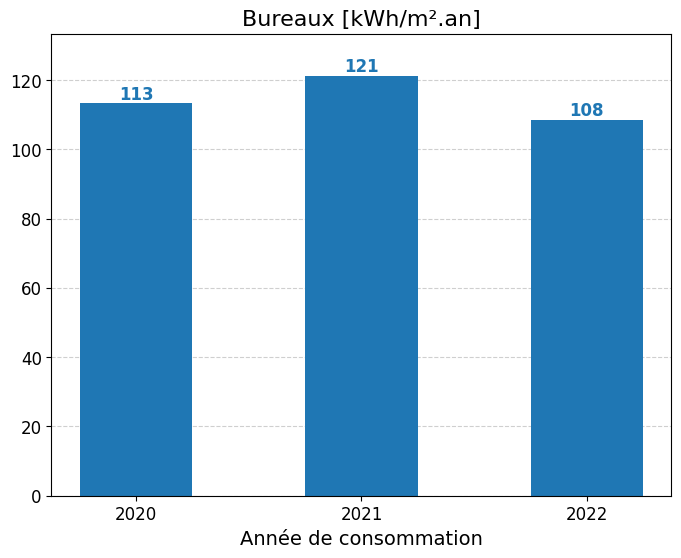

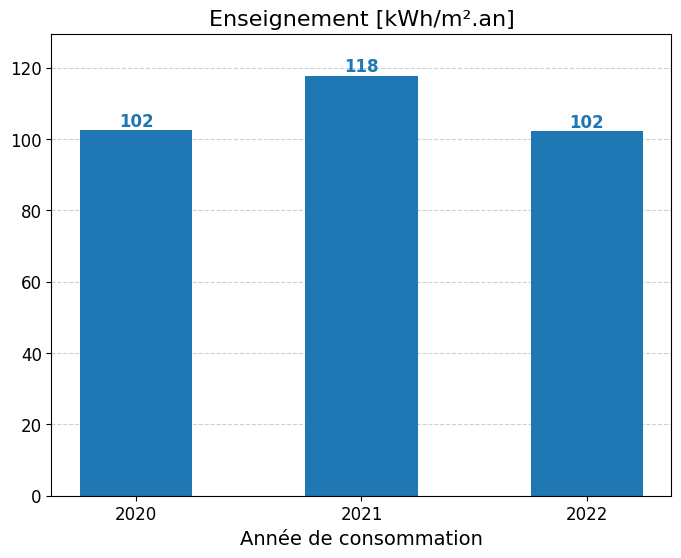

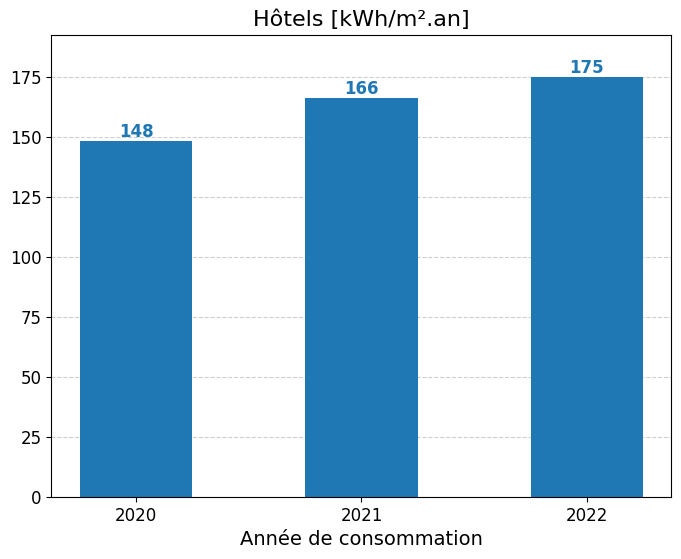

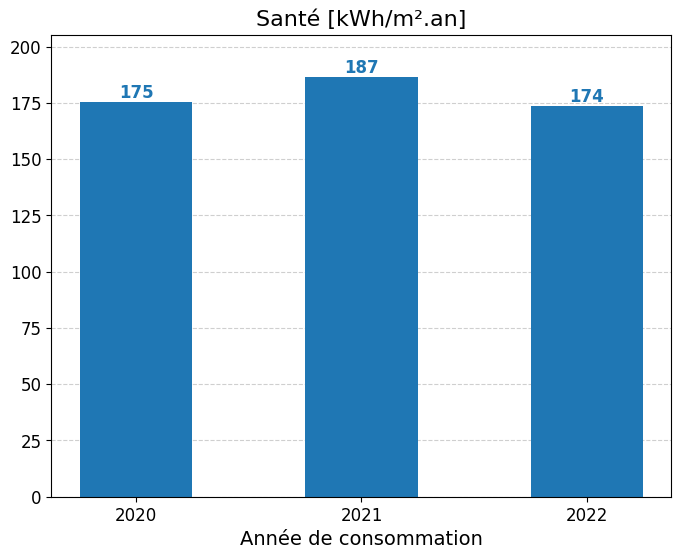

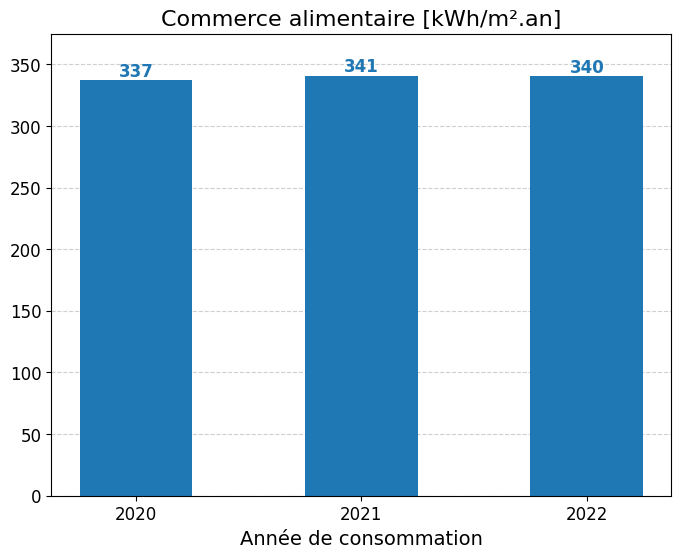

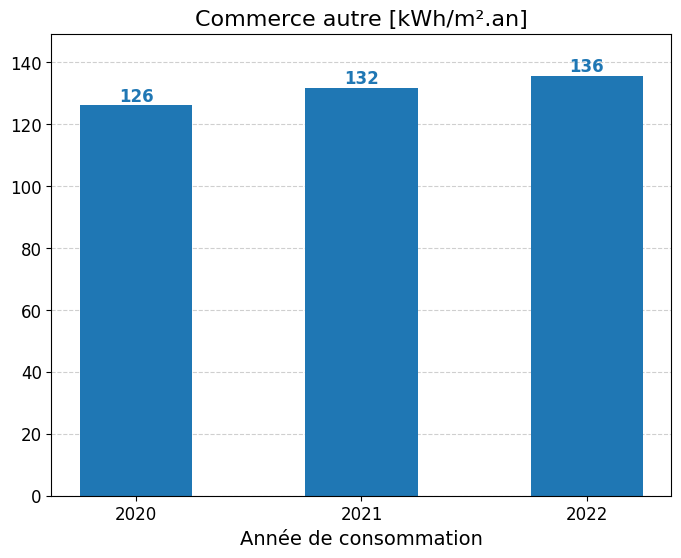

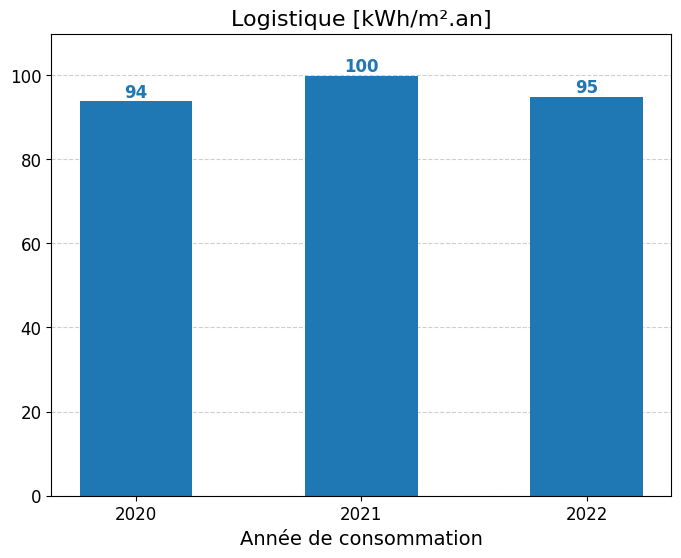

In [277]:
# Plotting
for meta_cap in ['Bureaux', 'Enseignement', 'Hôtels', 'Santé', 'Commerce alimentaire', 'Commerce autre', 'Logistique']:
    fig, ax = plt.subplots(figsize=(8, 6))
    width = 0.5  # Adjust the width of the bars as needed
    bars = ax.bar(distrib_meta_cap.loc[meta_cap].index, distrib_meta_cap.loc[meta_cap], width=width, zorder=2)
    ax.set_xlabel('Année de consommation', fontsize=14)
    ax.set_title("{} [kWh/m².an]".format(meta_cap), fontsize=16)
    ax.grid(True, axis='y', linestyle='--', alpha=0.6, zorder=1)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    for bar in bars.patches:
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), int(round(bar.get_height(),0)), 
                ha='center', va='bottom', fontsize=12, zorder=3, color='tab:blue', weight='bold')
    ax.set_ylim(0, distrib_meta_cap.loc[meta_cap].max()*1.1)
    fig_name = "evolution_ef_{}.png".format(unicodedata.normalize('NFKD', meta_cap).encode('ASCII', 'ignore').decode('ASCII').lower())
    plt.savefig(fig_name, bbox_inches='tight')
    plt.show()

In [256]:
# Périmètre
threshold_CAP = 90
years = ['2020', '2021', '2022']
df_extract = df.loc[df["P&S Score"] >= 9].loc[df["E Score"] >= 3].loc[df["Annee Consommation"].isin(years)]
surf_ratio = df_extract["Surface moyenne annuelle catégorie d'activité majoritaire (m²)"]/df_extract["Surface moyenne annuelle"]
df_extract = df_extract.loc[surf_ratio[surf_ratio >= threshold_CAP/100].index].loc[df_extract["Code CAP-M"] != "CAP00"]

# Nb données par code CAP-M par année
EFA_count = pd.DataFrame()
for year in years:
    df_1Y = df_extract.loc[df_extract['Annee Consommation'] == year]
    data = df_1Y['Code CAP-M'].value_counts().rename(year)
    EFA_count = pd.concat([EFA_count, data], axis=1)

# Conversion code --> catégorie abrégée
CAP_name_mapping = CAP.loc[CAP["Type"] == "Catégorie"][["Code", "Catégories abrégées"]].set_index('Code')['Catégories abrégées'].to_dict()
EFA_count_CAP = EFA_count.rename(index=CAP_name_mapping)
EFA_count_CAP = EFA_count_CAP.sort_index()
EFA_count_CAP.loc["TOTAL",:] = EFA_count_CAP.sum()
EFA_count_CAP = EFA_count_CAP.astype('int')

# Calcul par méta CAP
list_meta_cap = CAP["Méta-catégories"].value_counts().index.to_list()
to_exclude = ["Local vacant"] #"Accueil petite enfance", "Halles", "Parc à thèmes", "Parc d'expositions"]
meta_cap_all = {meta_cap: CAP.loc[CAP["Méta-catégories"] == meta_cap]["Code"].value_counts().index.to_list() for meta_cap in list_meta_cap if meta_cap not in to_exclude}

EFA_count_meta_CAP = pd.DataFrame(index = meta_cap_all.keys(), columns = EFA_count.columns)
for meta_cap in meta_cap_all:
    EFA_count_meta_CAP.loc[meta_cap, :] = EFA_count.loc[meta_cap_all[meta_cap]].sum()
EFA_count_meta_CAP = EFA_count_meta_CAP.sort_index()
EFA_count_meta_CAP.loc["TOTAL",:] = EFA_count_meta_CAP.sum()
EFA_count_meta_CAP = EFA_count_meta_CAP.astype('int')

In [257]:
EFA_count_CAP

,2020,2021,2022
Accueil petite enfance,1695,1695,1168
Audiovisuel - Radio,78,78,67
Audiovisuel - TV,133,134,103
Blanchisserie,283,281,179
Bureaux,36973,37027,26934
Camping,24,23,13
Commerce de gros,2952,2973,1830
Culture - Bibliothèques,986,981,641
Culture - Spectacle vivant,1829,1810,1153
Culture - Zoo,82,79,41


In [258]:
EFA_count_meta_CAP

,2020,2021,2022
Accueil petite enfance,1695,1695,1168
Audiovisuel,211,212,170
Blanchisserie,283,281,179
Bureaux,36973,37027,26934
Commerce alimentaire,9283,9052,6808
Commerce autre,22124,22073,17268
Commerce de gros,2952,2973,1830
Culture,4157,4129,2666
Enseignement,18469,18243,12095
Halles,138,141,60
